In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import gaussian_kde

In [13]:
# dataset name
csv_file = "realData.csv"
# make dataframe of data
df = pd.read_csv(csv_file)

# remove outliers (words longer than 10 characters)
df_filtered = df[df["length"] <= 10]

print(df_filtered.head())

  word_JAP          word_US word_POS phrase_JAP             img_title  \
0       新装  Newly available     noun        新装板  DL-Raw.Net_1 (2).jpg   
1        板            Board  unknown        新装板  DL-Raw.Net_1 (2).jpg   
2       板垣          Itagaki     noun       板垣恵介  DL-Raw.Net_1 (2).jpg   
3       恵介          Keisuke     noun       板垣恵介  DL-Raw.Net_1 (2).jpg   
4       新装  Newly available     noun        新装板      DL-Raw.Net_1.jpg   

   img_series  length  confidence  word_freq  hiragana_ratio  katakana_ratio  \
0  Hanma_Baki       2        0.65     0.0006             0.0             0.0   
1  Hanma_Baki       1        0.65     0.0014             0.0             0.0   
2  Hanma_Baki       2        0.96     0.0043             0.0             0.0   
3  Hanma_Baki       2        0.96     0.0045             0.0             0.0   
4  Hanma_Baki       2        0.88     0.0006             0.0             0.0   

   kanji_ratio  
0          1.0  
1          1.0  
2          1.0  
3          1

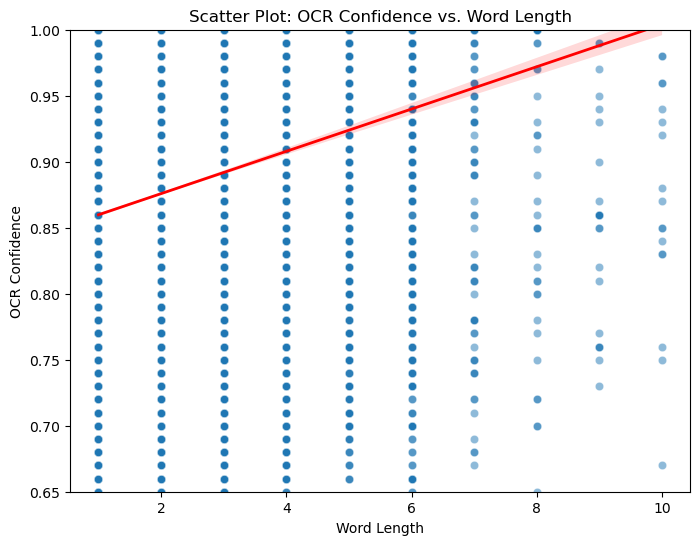

In [ ]:
# plot 1: scatter plot of word length vs. OCR confidence
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_filtered["length"], y=df_filtered["confidence"], alpha=0.5)

# red regression line
sns.regplot(x=df_filtered["length"], y=df_filtered["confidence"], scatter=False, color="red", line_kws={"linewidth": 2})

# y-axis limit between 0.65 and 1 (because 0.65 minimum confidence set during data creation)
plt.ylim(0.65, 1)

plt.xlabel("Word Length")
plt.ylabel("OCR Confidence")
plt.title("Scatter Plot: OCR Confidence vs. Word Length")

plt.show()

In [ ]:
# filter words with more than 15 characters
long_words = df[df["word_JAP"].str.len() > 15][["word_JAP", "word_US"]]

print(long_words)

                   word_JAP                                word_US
10461      アニメパキスベシャルブックレット             Anime Paki Special Booklet
12679    ドユアチヨコレトユラボレツョンツャツ  Douya Chocolate Yura Bore Tsyon Paste
28671      チャンビオンコミックスエクストラ                  Champion Comics Extra
29251     テセソビオソユミックスエクスドラン             Tesse Sobio Soy Mix Exdran
29844    シヨンバキスペシャルブツクレツトベヅ         Shionbaki Special Booklet Bezu
31037  レアニメションバキスペシャルブックレット       Reanimation Baki Special Booklet
34091      チャンビオンコミツクスエクストラ                  Champion Comics Extra
34206      チャンビオンコミツクスエクストラ                  Champion Comics Extra
34643     オリジナルチャンピオンマクワッペン             Original Champion McPappen


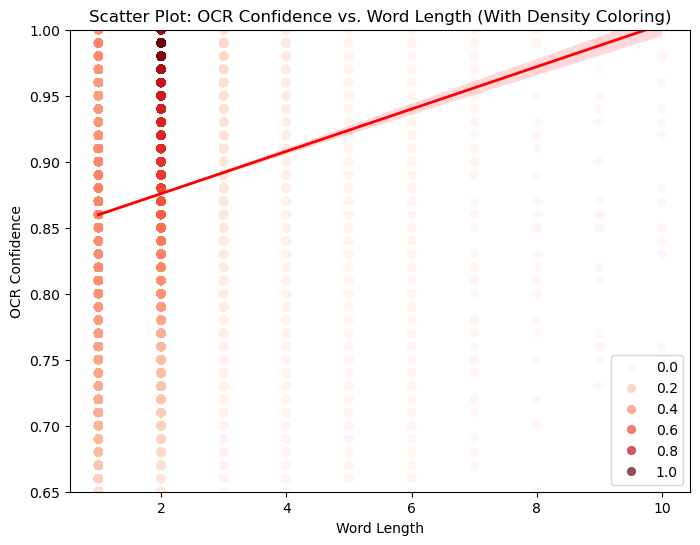

In [21]:
# calculate point density using gaussian_kde (Kernel Density Estimation)
xy = np.vstack([df_filtered['length'], df_filtered['confidence']])
kde = gaussian_kde(xy)  # create a KDE object
density = kde(xy)  # get density values for each point

# normalize density values for coloring
norm_density = (density - np.min(density)) / (np.max(density) - np.min(density))

# plot 1: Scatter plot of word length vs. OCR confidence (with density coloring)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_filtered["length"], 
    y=df_filtered["confidence"], 
    alpha=0.7, 
    hue=norm_density,
    palette="Reds",  # Red color palette
    edgecolor=None 
)

# red regression line
sns.regplot(x=df_filtered["length"], y=df_filtered["confidence"], scatter=False, color="red", line_kws={"linewidth": 2})

# y-axis limit between 0.65 and 1 (because 0.65 minimum confidence set during data creation)
plt.ylim(0.65, 1)

plt.xlabel("Word Length")
plt.ylabel("OCR Confidence")
plt.title("Scatter Plot: OCR Confidence vs. Word Length (With Density Coloring)")

plt.show()